In [3]:
import pandas as pd
import re
import nltk
nltk.download('punkt')

# Load CSV
df = pd.read_csv("Speech_Completion_Prediction_Dataset.csv")

# Select necessary columns
df = df[["VideoTitle", "Transcript"]]

# Drop missing values
df.dropna(inplace=True)

# Define a preprocessing function
def clean_transcript(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text)                  # remove extra whitespace
    text = re.sub(r'\[.*?\]', '', text)               # remove content in brackets
    text = re.sub(r'[^\w\s.,!?]', '', text)           # remove special characters
    text = re.sub(r'http\S+', '', text)               # remove URLs
    return text.strip()

# Apply cleaning
df["Transcript"] = df["Transcript"].apply(clean_transcript)

# Preview cleaned data
df.head()


[nltk_data] Downloading package punkt to C:\Users\IIIMaths-Sai
[nltk_data]     Lakshmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,VideoTitle,Transcript
0,Muniba_Mazari,"Whoa. Im running short of words right now, but..."
1,RIHANNA,So I made it to Harvard. Never thought Id be a...
2,Mr_Bean,My starting point when it comes to the conside...
3,Nita_Ambani,"In India, women are discriminated against even..."
4,Joe_Biden,"Hello, my fellow Americans and the people who ..."


In [5]:
# Step 2: Chunk Transcript (2–3 Sentences Each)
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

def chunk_text(text, chunk_size=3):
    sentences = sent_tokenize(text)
    return [" ".join(sentences[i:i + chunk_size]) for i in range(0, len(sentences), chunk_size)]

chunks = []

for idx, row in df.iterrows():
    chunked = chunk_text(row["Transcript"])
    for i, chunk in enumerate(chunked):
        chunks.append({
            "VideoTitle": row["VideoTitle"],
            "Chunk_ID": i,
            "Chunk_Text": chunk
        })

df_chunks = pd.DataFrame(chunks)
df_chunks.to_csv("SRFP/chunked_transcripts.csv", index=False)
df_chunks.head()


[nltk_data] Downloading package punkt to C:\Users\IIIMaths-Sai
[nltk_data]     Lakshmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,VideoTitle,Chunk_ID,Chunk_Text
0,Muniba_Mazari,0,"Whoa. Im running short of words right now, but..."
1,Muniba_Mazari,1,Thank you for accepting me. Thank you very muc...
2,Muniba_Mazari,2,And that disclaimer is that Ive never claimed ...
3,Muniba_Mazari,3,"Its the story of a woman who, in pursuit of he..."
4,Muniba_Mazari,4,Many people speak before they think that I kno...


2025-07-12 12:47:46,825 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2025-07-12 12:54:34,116 - BERTopic - Embedding - Completed ✓
2025-07-12 12:54:34,119 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-12 12:54:59,998 - BERTopic - Dimensionality - Completed ✓
2025-07-12 12:54:59,999 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-12 12:55:05,448 - BERTopic - Cluster - Completed ✓
2025-07-12 12:55:05,461 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-12 12:55:06,547 - BERTopic - Representation - Completed ✓


     Topic  Count                                               Name  \
0       -1   1454                             -1_people_like_know_im   
1        0    188                    0_india_indian_indias_australia   
2        1    156                           1_movie_film_movies_star   
3        2     76                       2_fear_scared_airplane_fears   
4        3     60              3_road_road safety_safety_enforcement   
..     ...    ...                                                ...   
127    126      5                126_sense purpose_nominee_joe_chose   
128    127      5  127_theyre americans_americans_laws demanding_...   
129    128      5              128_wont like_lucky_wasnt_noisy wasnt   
130    129      5      129_manipulated_women_manipulated fear_theory   
131    130      5                  130_aspire make_wise_aspire_later   

                                        Representation  \
0    [people, like, know, im, just, want, dont, wor...   
1    [india, indian

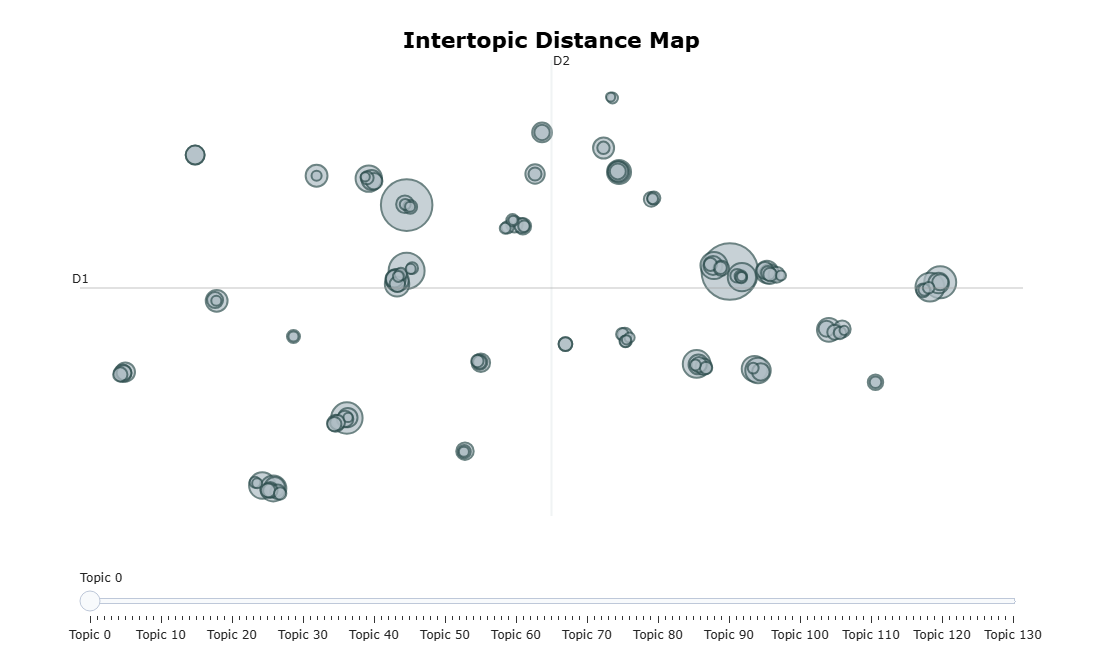

In [27]:
from bertopic import BERTopic
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# ✅ Load your data
df = pd.read_csv("SRFP/chunked_transcripts.csv")  # Update filename if needed
docs = df["Chunk_Text"].tolist()

# ✅ UMAP for dimensionality reduction
umap_model = UMAP(
    n_neighbors=10,      # Controls local vs global structure
    n_components=5,      # Dimensionality (lower = more general clusters)
    min_dist=0.1,        # Lower means tighter clusters
    metric='cosine',
    random_state=42
)

# ✅ HDBSCAN for clustering
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=5,            # Minimum size for a topic
    metric='euclidean',
    cluster_selection_method='eom', # Better separation
    prediction_data=True
)

# ✅ CountVectorizer for topic representations
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words="english"
)

# ✅ BERTopic Initialization
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True,
    top_n_words=10,
    min_topic_size=5,
    low_memory=True
)

# ✅ Fit the model
topics, probs = topic_model.fit_transform(docs)

# ✅ Assign topics back
df["Topic_Label"] = topics

# ✅ Save the data
df.to_csv("SRFP/chunked_with_topics_refined.csv", index=False)

# ✅ Explore topics
topic_info = topic_model.get_topic_info()
print(topic_info)

# ✅ Optional visualization
topic_model.visualize_topics()


In [31]:
import pandas as pd

# Load your topic-labeled data (adjust path as needed)
df = pd.read_csv("SRFP/chunked_with_topics_refined.csv")
print(df.columns)

# Show how many -1 labels exist
print("🟠 Number of unassigned (-1) topics:", (df["Topic_Label"] == -1).sum())

# Convert Topic to int if needed
df["Topic_Label"] = df["Topic_Label"].astype(int)

# ✅ Reassign -1s by majority topic within the same video
def replace_outliers_with_majority(group):
    most_common = group.loc[group["Topic_Label"] != -1, "Topic_Label"].mode()
    replacement = most_common.iloc[0] if not most_common.empty else 0
    group["Reassigned_Topic"] = group["Topic_Label"].replace(-1, replacement)
    return group

df = df.groupby("VideoTitle", group_keys=False).apply(replace_outliers_with_majority)

# ✅ Check result
print("✅ Unique topics after reassignment:", df["Reassigned_Topic"].unique())
print(df[["VideoTitle", "Chunk_ID", "Reassigned_Topic"]].head())

# Save for next steps
df.to_csv("SRFP/chunked_with_topics_refined.csv", index=False)


Index(['VideoTitle', 'Chunk_ID', 'Chunk_Text', 'Topic_Label'], dtype='object')
🟠 Number of unassigned (-1) topics: 1454
✅ Unique topics after reassignment: [  4  19  73  10   2  54  24 110  85  32 101  11  17  39   9  33 108 114
   6  18  37  94   7  99 128   0  36  14  86  45  91  62 127 103   1  25
  61  83  60  35  47  63 100  97  16  38 123  67  23   5  29  21  79  80
  70  98 122  44  78  77  46 125  22   8  58  59  48  13  31  50  52  56
  84  64  72  57 130  49  74 121  34  28  71 113  65 124  96  43  66  75
  69 116  55  76  82  30  93  92  15 102  90  12  42  41  20 104 105  88
 120 129  26 115  40  81  51 117 107 118 119  53 109  89 111  87 126  27
  95  68   3 106 112]
      VideoTitle  Chunk_ID  Reassigned_Topic
0  Muniba_Mazari         0                 4
1  Muniba_Mazari         1                 4
2  Muniba_Mazari         2                19
3  Muniba_Mazari         3                19
4  Muniba_Mazari         4                19


C:\Users\IIIMaths-Sai Lakshmi\AppData\Local\Temp\ipykernel_13164\3268771294.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [33]:

import pandas as pd
import numpy as np

# Assuming your DataFrame is `df`
df = pd.read_csv("SRFP/chunked_with_topics_refined.csv")  # or the latest file

# ✔️ Check Topic Labels
print("Unique Topic Labels:", df["Reassigned_Topic"].unique())

# ✅ Recompute Cumulative Unique Topics
df["Cumulative_Unique_Topics"] = (
    df.groupby("VideoTitle")["Reassigned_Topic"]
    .transform(lambda x: x.expanding().apply(lambda s: len(set(s)), raw=False))
)

# ✔️ Check for correctness
print(df[["VideoTitle", "Chunk_ID", "Reassigned_Topic", "Cumulative_Unique_Topics"]].head())

# ✅ Adaptive Saturation Detection
def detect_saturation(group, window=3):
    counts = group["Cumulative_Unique_Topics"].values
    diffs = np.diff(counts)
    for i in range(len(diffs) - window):
        if np.all(diffs[i:i+window] == 0):
            return group["Chunk_ID"].iloc[i + window]
    return group["Chunk_ID"].iloc[-1]  # If no saturation found, use last chunk

saturation_info = (
    df.groupby("VideoTitle")
    .apply(lambda g: pd.Series({
        "Saturation_Chunk_Position": detect_saturation(g),
        "Total_Chunks": len(g),
        "Estimated_Completion_%": round(
            (detect_saturation(g) / len(g)) * 100, 2)
    }))
    .reset_index()
)

# ✅ Merge saturation info back
df_final = df.merge(saturation_info, on="VideoTitle")

# ✅ Save final
df_final.to_csv("SRFP/final_topic_modeling.csv", index=False)

print("✅ Completed pipeline.")


Unique Topic Labels: [  4  19  73  10   2  54  24 110  85  32 101  11  17  39   9  33 108 114
   6  18  37  94   7  99 128   0  36  14  86  45  91  62 127 103   1  25
  61  83  60  35  47  63 100  97  16  38 123  67  23   5  29  21  79  80
  70  98 122  44  78  77  46 125  22   8  58  59  48  13  31  50  52  56
  84  64  72  57 130  49  74 121  34  28  71 113  65 124  96  43  66  75
  69 116  55  76  82  30  93  92  15 102  90  12  42  41  20 104 105  88
 120 129  26 115  40  81  51 117 107 118 119  53 109  89 111  87 126  27
  95  68   3 106 112]
      VideoTitle  Chunk_ID  Reassigned_Topic  Cumulative_Unique_Topics
0  Muniba_Mazari         0                 4                       1.0
1  Muniba_Mazari         1                 4                       1.0
2  Muniba_Mazari         2                19                       2.0
3  Muniba_Mazari         3                19                       2.0
4  Muniba_Mazari         4                19                       2.0
✅ Completed pipeline

C:\Users\IIIMaths-Sai Lakshmi\AppData\Local\Temp\ipykernel_13164\2948849727.py:30: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [35]:
print(df.columns)

Index(['VideoTitle', 'Chunk_ID', 'Chunk_Text', 'Topic_Label',
       'Reassigned_Topic', 'Cumulative_Unique_Topics'],
      dtype='object')


In [37]:
print(df.columns.tolist())


['VideoTitle', 'Chunk_ID', 'Chunk_Text', 'Topic_Label', 'Reassigned_Topic', 'Cumulative_Unique_Topics']


In [39]:
import matplotlib.pyplot as plt
import os

# Create output folder if it doesn't exist
output_dir = "SRFP/results/plots/topic_progression/reassigned"
os.makedirs(output_dir, exist_ok=True)

# Loop over each video and plot its topic progression
for title, group in df.groupby("VideoTitle"):
    plt.figure(figsize=(8, 4))
    plt.plot(group["Chunk_ID"], group["Cumulative_Unique_Topics"], marker='o', color='teal')
    plt.title(f"Topic Progression: {title}", fontsize=12)
    plt.xlabel("Chunk Index")
    plt.ylabel("Cumulative Unique Topics")
    plt.grid(True)
    plt.tight_layout()

    # Clean title to use in filename
    safe_title = "".join(c for c in title if c.isalnum() or c in (' ', '-', '_')).rstrip()
    filename = os.path.join(output_dir, f"{safe_title}.png")

    # Save the figure
    plt.savefig(filename)
    plt.close()



In [43]:
import matplotlib.pyplot as plt
import os
import re
# ✅ Load final processed data
import pandas as pd

df_final = pd.read_csv("SRFP/final_topic_modeling.csv")


output_dir = "results/plots/topic_progression/reassigned"
os.makedirs(output_dir, exist_ok=True)

for video_title, group in df_final.groupby("VideoTitle"):
    chunk_ids = group["Chunk_ID"].values
    cumulative_topics = group["Cumulative_Unique_Topics"].values
    saturation_chunk = group["Saturation_Chunk_Position"].iloc[0]

    if saturation_chunk in chunk_ids:
        saturation_topic = group[group["Chunk_ID"] == saturation_chunk]["Cumulative_Unique_Topics"].values[0]

        plt.figure(figsize=(8, 4))
        plt.plot(chunk_ids, cumulative_topics, marker="o", label="Cumulative Unique Topics")
        plt.axvline(x=saturation_chunk, color="red", linestyle="--", label="Saturation Point")
        plt.axhline(y=saturation_topic, color="gray", linestyle="--", alpha=0.5)
        plt.title(f"Topic Saturation – {video_title}")
        plt.xlabel("Chunk ID")
        plt.ylabel("Cumulative Unique Topics")
        plt.legend()
        plt.tight_layout()

        safe_title = re.sub(r'[\\/*?:"<>|]', "_", video_title)
        plt.savefig(f"{output_dir}/{safe_title}_saturation_plot.png")
        plt.close()

    else:
        print(f"⚠️ Skipping plot: Chunk ID {saturation_chunk} not found in '{video_title}'")


In [45]:
df2 = pd.read_csv("SRFP/final_topic_modeling.csv")

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Only keep one row per speech for prediction
df_speech_level = df2.drop_duplicates(subset=["VideoTitle"])[
    ["Saturation_Chunk_Position", "Total_Chunks", "Estimated_Completion_%"]
]

# Define features and target
X = df_speech_level[["Saturation_Chunk_Position", "Total_Chunks"]]
y = df_speech_level["Estimated_Completion_%"]

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Initialize and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error: 1.47
R² Score: 0.90


In [57]:
import os

# Make sure the directory exists
os.makedirs("SRFP/models", exist_ok=True)

# Now save the model
topic_model.save("SRFP/models/final_bertopic_model")


# Save Regressor
import joblib
joblib.dump(rf, "SRFP/models/completion_predictor.pkl")


2025-07-12 13:06:32,593 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


['SRFP/models/completion_predictor.pkl']